<h3>Problem<h3>    
The project is to predict river flow one week ahead given measurements of past river flow, precipitation and temperature. 

- Input data is weather_data.nc with the 1 streamflow station and 9 meteorological stations (P, T)
    
- The objective is to predict streamflow one week ahead from the observations of flow, precipitation and temperature available up to the current day   


<h3>Solution<h3>  
    
This is the typical weather forecast modeling:
    
- The input are 9 surrounding meteorological stations with observed Precipitation and Temperature
- The output is river flow.    

For this type of problem, I am gonna apply Recurrent Neural Network (RNN) using Precipitation, Temperature and historical streamflow to forecast the streamflow in the next 7 days using previous 30 days historical data.

<h4>Model<h4> 
The following package are used:
    
- Keras version 2.4.3
- Tensorflow version 2.3
- The RNN in use is Long Short Term Memory model
- The platform is running using Palmetto supercomputer @ Clemson University, using 1 Tesla GPU K40 with 16 cores and 62 gb ram.

In [1]:
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
import keras
from datetime import date, timedelta

In [2]:
# Load netcdf dataset
fh = Dataset('weather_data.nc', mode='r')

flow    = fh.variables['flow'][:]
temp    = fh.variables['temperature'][:]
prec    = fh.variables['precipitation'][:]
timQ    = fh.variables['time_flow'][:]
timW    = fh.variables['time_weather'][:]
stan    = fh.variables['station_number'][:]

fh.close()


In [3]:
timeQ = pd.to_datetime(timQ, unit='D',
               origin=pd.Timestamp('1958-01-04'))
timeW = pd.to_datetime(timW, unit='D',
               origin=pd.Timestamp('1957-01-01'))

There are 9 meteorological stations with P and T records. In this study, I will use ALL 9 stations for simplicity. However, in the real project, we can trim down the number of stations due to collinearity using PCA or LASSO approach. Trim down number of stations can significantly reduct the computation time as well as to avoid overfitting

In [4]:
Weather_cols = ['p1','p2','p3','p5','p5','p6','p7','p8','p9',
               't1','t2','t3','t5','t5','t6','t7','t8','t9']
Weather_data = pd.concat([pd.DataFrame(prec),pd.DataFrame(temp)],axis=1)
Weather_data.columns = Weather_cols
Weather_data['date']=timeW

The historical flow data is also used for forecast:

In [5]:
Flow_data = pd.DataFrame()
Flow_data["Q"] = flow
Flow_data['date']=timeQ

Create the dataset with 18 stations' P&T data and 1 flow data. All having same date/time

In [6]:
All_data = pd.merge(Weather_data,Flow_data,how="inner",on="date")
All_data.index = All_data["date"]
All_data = All_data.drop("date",axis=1)

In this study, I am gonna forecast the streamflow for the date "2010-10-17".
I use 30 past daily data to forecast the the next 7 day streamflow.: "2010-09-11" to "2010-10-10"

The data used for training & testing will be spanning from "1958-01-04" to "2010-09-09"
The data used for actual forecasting will be spanning from : "2010-09-10" to "2010-10-17": 30+7 days 


In [7]:
date_forecast = "2010-10-17"
past = 30
future = 7
date_exclude = pd.to_datetime(date_forecast)-timedelta(past+future)

Create training & testing data: "1958-01-04" to "2010-09-09"

In [8]:
ind = np.where(All_data.index==date_exclude)
indx=int(ind[0])
train_test = All_data.iloc[0:indx,:]

Create validation data for forecasting: "2010-09-10" to "2010-10-17":

In [9]:
val_data   = All_data.iloc[indx:(indx+past+future+1),:]

For training_testing data, I use 70% for training and 30% for testing.
For Neural Network, the input data will be normalized

For both training & testing set, I use 500 batch each among 13500 training and 5800 testing data.
For each batch, I use 30 historical data in the past to forecast the next 7 days data.
The learning_rate and number of epochs are chosen as 0.001 and 10 but can be changed later on to optimize the model.


In [10]:
split_fraction = 0.7
train_split = int(split_fraction * int(train_test.shape[0]))

batch_size = 500
learning_rate = 0.001
epochs = 10

Normalized train & test set

In [11]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(0,1))
scaled_features = pd.DataFrame(scale.fit_transform(train_test))
scaled_features.columns = train_test.columns
scaled_features.index = train_test.index
train_data = scaled_features[0:train_split]
test_data =  scaled_features[train_split:]

Split training & testing data

Prepare predictors (x_train) and predictand (y_train) for training data

In [12]:
start = future
end = start + train_split

x_train = train_data
y_train = scaled_features[start:end]["Q"]

sequence_length = past

For training data set, the updated keras (with tensorflow version 2.3 and above) has built-in function to prepare for time series modeling using given batch size and the length for historical data.

In [13]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    batch_size=batch_size,
)

In [14]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (500, 30, 19)
Target shape: (500,)


Build RNN model using Long Short Term Memory model (LSTM). In this study, I use stacked LSTM hidden layer with 32 nodes.
As the requirement is the forecast for the flow 1 week ahead, so there is only 1 output here.

The Optimizer is the Adam algorithm.

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
According to Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

The loss function is mean_squared_error (mse)

In [15]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32, activation="relu")(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()    

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 19)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6656      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


Split data for testing data set using keras preprocessing timeseries function

In [16]:
x_end = len(test_data) - future

label_start = train_split + future

x_test = test_data.iloc[:x_end,:]
y_test = scaled_features.iloc[label_start:]["Q"]

dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    batch_size=batch_size
)

In [17]:
for batch in dataset_test.take(1):
    inputs_test, targets_test = batch

print("Input shape:", inputs_test.numpy().shape)
print("Target shape:", targets_test.numpy().shape)

Input shape: (500, 30, 19)
Target shape: (500,)


In [18]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_test   
)

Epoch 1/10
27/27 [==============================] - 2s 67ms/step - loss: 0.0354 - val_loss: 0.0155
Epoch 2/10
27/27 [==============================] - 2s 61ms/step - loss: 0.0139 - val_loss: 0.0131
Epoch 3/10
27/27 [==============================] - 2s 63ms/step - loss: 0.0126 - val_loss: 0.0128
Epoch 4/10
27/27 [==============================] - 2s 61ms/step - loss: 0.0123 - val_loss: 0.0124
Epoch 5/10
27/27 [==============================] - 2s 61ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 6/10
27/27 [==============================] - 2s 62ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 7/10
27/27 [==============================] - 2s 61ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 8/10
27/27 [==============================] - 2s 61ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 9/10
27/27 [==============================] - 2s 61ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 10/10
27/27 [==============================] - 2s 61ms/step - loss: 0.0031 - val_loss: 0.0037


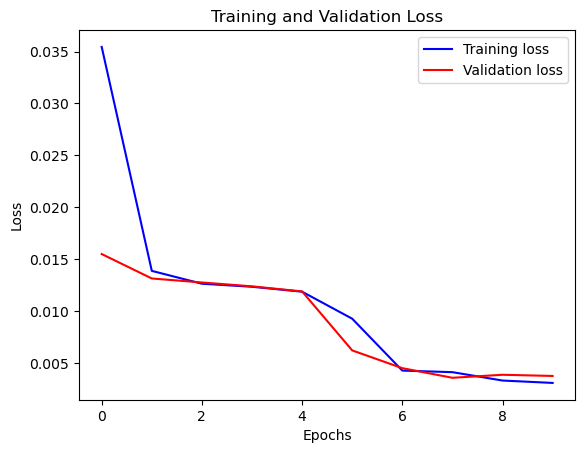

In [19]:
import matplotlib.pyplot as plt
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [20]:
y_predict = model.predict(inputs_test)

In [21]:
flowtt = np.array(train_test["Q"])
flowtt = flowtt.reshape(flowtt.shape[0],1)
sc1 = MinMaxScaler(feature_range=(0,1))
sc1.fit_transform(flowtt)
y_predict_descaled = sc1.inverse_transform(y_predict)
y_test_descaled    = sc1.inverse_transform(np.array(targets_test).reshape(targets_test.shape[0],1))

y_predict_descaled[y_predict_descaled<0]=0

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

R2 = r2_score(y_test_descaled,y_predict_descaled)
MSE = mean_squared_error(y_test_descaled,y_predict_descaled)

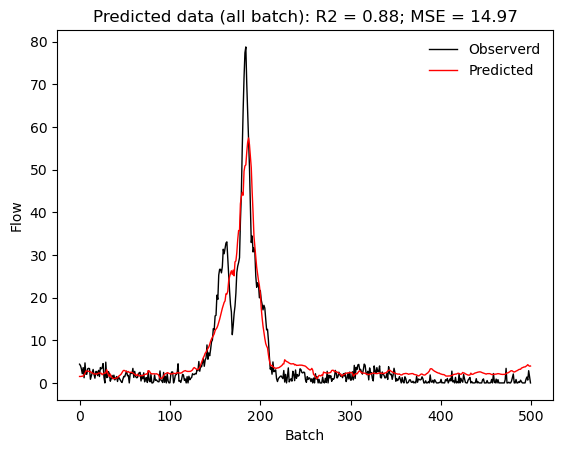

In [23]:
plt.plot(y_test_descaled, color = 'black', linewidth=1, label = 'Observerd')
plt.plot(y_predict_descaled, color = 'red',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Flow")
plt.xlabel("Batch")
plt.title("Predicted data (all batch): " + "R2 = " + str(round(R2,2))+"; MSE = " + str(round(MSE,2)))
plt.show()

In [24]:
scaled_val_data = scale.fit_transform(val_data.values)
scaled_x_val = scaled_val_data[1:31]
x_val = scaled_x_val.reshape(1,scaled_x_val.shape[0],scaled_x_val.shape[1])

In [25]:
y_7d = model.predict(x_val)
y_predict_descaled1 = sc1.inverse_transform(y_7d)

In [26]:
y_predict_descaled1

array([[12.142197]], dtype=float32)

In [27]:
yobs = val_data["Q"][37]

In [28]:
yobs

2.1856861094513413